<a href="https://colab.research.google.com/github/19CWI/SpamClassifier/blob/main/Cogs400_spamClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

dataset:  https://www.kaggle.com/datasets/veleon/ham-and-spam-dataset

In [ ]:
cd "/content/drive/MyDrive/Colab Notebooks/datasets/spamMailDataset"

/content/drive/MyDrive/Colab Notebooks/datasets/spamMailDataset


In [ ]:
rm -rf ham/ hamnspam/ spam/

In [ ]:
!unzip archive.zip

In [ ]:
ls

In [ ]:
dataLocation = "/content/drive/MyDrive/Colab Notebooks/datasets/spamMailDataset/hamnspam/"

In [ ]:
import pandas as pd
import numpy as np
import sklearn.model_selection
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import email
import email.policy
from bs4 import BeautifulSoup

In [ ]:
ham_filenames = [name for name in sorted(os.listdir(dataLocation + 'ham')) if len(name) > 20] #get file names
spam_filenames = [name for name in sorted(os.listdir(dataLocation + 'spam')) if len(name) > 20]
len(ham_filenames), len(spam_filenames)

(2551, 501)

In [ ]:
def load_email(is_spam, filename): #opens and loads email into email object
  directory = dataLocation+ "spam" if is_spam else dataLocation + "ham"
  with open(os.path.join(directory, filename), "rb") as f:
    return email.parser.BytesParser(policy=email.policy.default).parse(f)
    

In [ ]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames] #loads all emails
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [ ]:
def html_to_plain(email): #self explanitory
    try:
        soup = BeautifulSoup(email.get_content(), 'html.parser')
        return soup.text.replace('\n\n','')
    except:
        return None

In [ ]:
def parseMail(emails,label,data,defaultSubject=None): #parces readable formats in a list of emails and extracts relavent information
  for email in emails:
    for part in email.walk():
      partContentType = part.get_content_type()
      if partContentType not in ['text/plain','text/html']:
        continue
      try:
        partContent = part.get_content()
      except: # in case of encoding issues
        partContent = str(part.get_payload())
      subject=part['Subject']
      if(subject is None):
        data['subject'].append(defaultSubject)
      else:
        data['subject'].append(" "+subject+" ")
      if partContentType == 'text/plain':
        data['content'].append(" "+partContent+" ")
      else:
        data['content'].append(html_to_plain(part))
      data['label'].append(label)

In [ ]:
data = {'subject':[], 'content':[], 'label':[]} #parses all emails with classes into dataframe
parseMail(ham_emails,True,data)
parseMail(spam_emails,False,data)
df = pd.DataFrame(data)
df.dropna(inplace=True)

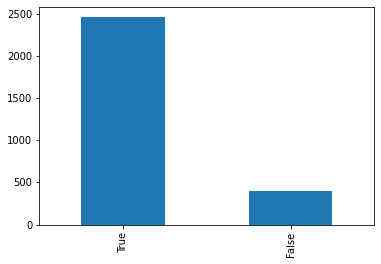

In [ ]:
df["label"].value_counts().plot(kind="bar")

In [ ]:
df.replace(to_replace="(<|>)", value= " ", inplace=True, regex=True) #remove this special character first, it's the bounds for my custom tokens
df.replace(to_replace="\s.*\@.*\s", value= " <mailAddress> ", inplace=True, regex=True)# replace email addresses
df.replace(to_replace="\s(http[s]?:|www\..*\.com).*\s", value= " <siteLink> ", inplace=True, regex=True)# replace websites
df.replace(to_replace="\s[s]?ftp:.*\s", value= " <ftpLink> ", inplace=True, regex=True) # replace ftp links
df.replace(to_replace="([^a-zA-Z0-9 <>:\'])", value= "", inplace=True, regex=True)# remove everything except alphanumerics and a couple special characters

df['subjectContent'] = [subject + " " + content for subject, content in zip(df['subject'], df['content'])] #combine subject and content into 1 feild

In [ ]:
maxFeature = 20000

tokenizer = tf.keras.preprocessing.text.Tokenizer( # tokenize vocabulary, keep top 20000
    num_words=maxFeature,
    filters='',
    lower=True, split=' ', char_level=False, oov_token='<OOV>'
)
tokenizer.fit_on_texts(subjectContent for subjectContent in df['subjectContent'].to_numpy())

In [ ]:
df = df.sample(frac=1) #shuffle dataset and split into train and test
y = df.pop('label').to_frame().astype(float)
X = df.pop('subjectContent').to_frame()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, y,stratify=y, test_size=0.15)

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer): #embedding layer
    def __init__(self, maxlen, vocab_size, embed_dim):
      super(TokenAndPositionEmbedding, self).__init__()
      self.embed_dim=embed_dim #size of vector representing each word
      self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
      self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
      maxlen = tf.shape(x)[-1]
      positions = tf.range(start=0, limit=maxlen, delta=1)
      positions = self.pos_emb(positions) # adds positional importance
      x = self.token_emb(x) # from token sequence to vector representations, doesn't train semantics exactly more like spam/ham polarity of tokens
      x *= tf.math.sqrt(tf.cast(self.embed_dim, tf.float32)) #scaling the embeddings to prevent the attention layers from either focusing consistently on one thing or from not focussing on anything at all
      return x + positions

In [ ]:
class LocalMultiHeadAttention(tf.keras.layers.Layer): #multihead attention layer
  def __init__(self, d_model, num_heads):
    super(LocalMultiHeadAttention, self).__init__()
    self.num_heads = num_heads #multiple heads allows for attention of different things at different positions
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size): #splits dimension so different positional information will be jointly attended to num_heads different ways
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
  
  def scaled_dot_product_attention(self, query, key, value, mask):#applies dot product attention to all input sequences
    QK_transpose = tf.matmul(query, key, transpose_b=True)
    d_k = tf.cast(tf.shape(key)[-1], tf.float32)
    attentionLogits = QK_transpose/tf.math.sqrt(d_k)
    if mask is not None: #tells the attention not to pay attention to certain words, eg null tokens
      attentionLogits += mask*-1000000000
    attentionWeights = tf.nn.softmax(attentionLogits)
    return tf.matmul(attentionWeights, value)

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    scaled_attention = self.scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, #accumulates the attention from all the heads
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model), 

    return output

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = LocalMultiHeadAttention(d_model, num_heads) #attention
    self.ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ]) #tries to glean the meaning off of what is being payed attention to

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)] #stacks encoders

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class SpamClassifier(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, num_classes = 1, rate=0.1):
    super().__init__()
    
    self.embedding = TokenAndPositionEmbedding(maximum_position_encoding, input_vocab_size, d_model)

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, rate)
    
    self.globalAveragePool = tf.keras.layers.GlobalAveragePooling1D()
    
    self.drop1 = tf.keras.layers.Dropout(rate)
    self.drop2 = tf.keras.layers.Dropout(rate)
    
    self.dense = tf.keras.layers.Dense(num_classes, activation='sigmoid')

  def call(self, inputs, training): #inputs = (batch_size, input sequence)
    enc_padding_mask = create_padding_mask2(inputs) #(batch_Size, 1, 1, sequenceLength) tells the model not to pay attention to null tokens

    # adding embedding and position encoding.
    x = self.embedding(inputs)  # x=(batch_size, input_seq_len, d_model)

    enc_output = self.encoder(x, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    feature_pool = self.globalAveragePool(enc_output) #smooths out the features the model identifies
    feature_pool = self.drop1(feature_pool)

    hamSpam = self.dense(feature_pool) #makes prediction based on the features
    hamSpam = self.drop2(hamSpam)

    return hamSpam

def create_padding_mask2(sequence): 
  return tf.cast(tf.math.equal(sequence, 0), tf.float32)[:,tf.newaxis,tf.newaxis,:]


In [ ]:
max_sentence_length=1024

In [ ]:
#uniformly sets all sequences to length 1024
token_train_set_temp = [np.squeeze(np.array([np.array(token) for token in tokenizer.texts_to_sequences(val)])) for val in X_train.values]
token_test_set_temp = [np.squeeze(np.array([np.array(token) for token in tokenizer.texts_to_sequences(val)])) for val in X_test.values]
token_train_set = []
token_test_set = []
zero = np.zeros((max_sentence_length))
for i in token_train_set_temp:
  # np.append(i,zero[max_sentence_length:]).shape
  if i.shape[0]<max_sentence_length:
    l = np.append(i,zero[i.shape[0]:])
  else:
    l = i[:max_sentence_length]
  token_train_set.append(l)
for i in token_test_set_temp:
  if i.shape[0]<max_sentence_length:
    l = np.append(i,zero[i.shape[0]:])
  else:
    l = i[:max_sentence_length]
  token_test_set.append(l)
token_train_set = np.array(token_train_set)
token_test_set = np.array(token_test_set)



In [ ]:
token_test_set.shape

(429, 1024)

In [ ]:
def evaluator(test_y, pred_y): #used for confusion matrix
  accuracy = np.sum(test_y == pred_y) / test_y.shape[0]
  confMatrix = np.zeros((2,2))
  for i in range(test_y.shape[0]):
    confMatrix[test_y[i].astype(int)][pred_y[i].astype(int)] += 1

  print('Confusion Matrix:')
  print(confMatrix)
  print('accurancy: ', accuracy)


In [ ]:
num_layers=1 #some default settings
d_model=16
dff=512
vocab_size=20000
max_sentence_length=1024
num_heads=4
dropout_rate=0.1


Epoch 1/10
76/76 [==============================] - 16s 173ms/step - loss: 0.4700 - accuracy: 0.7815
Epoch 2/10
76/76 [==============================] - 13s 172ms/step - loss: 0.4665 - accuracy: 0.7865
Epoch 3/10
76/76 [==============================] - 13s 172ms/step - loss: 0.4694 - accuracy: 0.7774
Epoch 4/10
76/76 [==============================] - 13s 172ms/step - loss: 0.3862 - accuracy: 0.9019
Epoch 5/10
76/76 [==============================] - 13s 171ms/step - loss: 0.3814 - accuracy: 0.9081
Epoch 6/10
76/76 [==============================] - 13s 171ms/step - loss: 0.3763 - accuracy: 0.9192
Epoch 7/10
76/76 [==============================] - 13s 171ms/step - loss: 0.3784 - accuracy: 0.9122
Epoch 8/10
76/76 [==============================] - 13s 171ms/step - loss: 0.3748 - accuracy: 0.9209
Epoch 9/10
76/76 [==============================] - 13s 171ms/step - loss: 0.3756 - accuracy: 0.9184
Epoch 10/10
76/76 [==============================] - 13s 172ms/step - loss: 0.3744 - accura

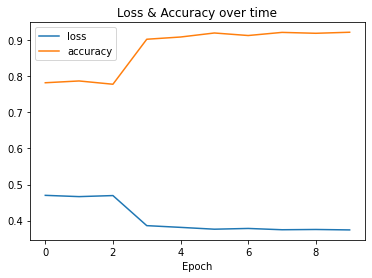

In [ ]:
model1 = SpamClassifier(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size= vocab_size,
    maximum_position_encoding=max_sentence_length,
    rate=dropout_rate)

model1.compile(optimizer = 'adam', 
                    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=['accuracy'])

history = model1.fit(token_train_set, y_train['label'], batch_size=32, epochs=10)

pd.DataFrame(history.history).plot(xlabel="Epoch")
plt.title("Loss & Accuracy over time")

y_pred = model1.predict(token_test_set)
print(sklearn.metrics.classification_report(y_test['label'].to_numpy(), np.around(y_pred)))
print()
print()
evaluator(y_test['label'].to_numpy(),np.around(y_pred).flatten())

Epoch 1/15
76/76 [==============================] - 58s 695ms/step - loss: 0.4714 - accuracy: 0.7766
Epoch 2/15
76/76 [==============================] - 53s 695ms/step - loss: 0.4675 - accuracy: 0.7852
Epoch 3/15
76/76 [==============================] - 53s 694ms/step - loss: 0.4717 - accuracy: 0.7766
Epoch 4/15
76/76 [==============================] - 53s 695ms/step - loss: 0.4595 - accuracy: 0.7968
Epoch 5/15
76/76 [==============================] - 53s 694ms/step - loss: 0.4064 - accuracy: 0.8718
Epoch 6/15
76/76 [==============================] - 53s 694ms/step - loss: 0.4032 - accuracy: 0.8594
Epoch 7/15
76/76 [==============================] - 53s 695ms/step - loss: 0.3854 - accuracy: 0.9027
Epoch 8/15
76/76 [==============================] - 53s 695ms/step - loss: 0.3848 - accuracy: 0.9056
Epoch 9/15
76/76 [==============================] - 53s 694ms/step - loss: 0.3893 - accuracy: 0.8974
Epoch 10/15
76/76 [==============================] - 53s 693ms/step - loss: 0.3868 - accura

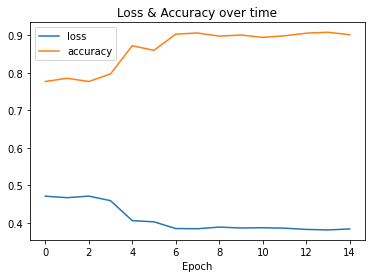

In [ ]:
model2 = SpamClassifier(
    num_layers=3,
    d_model=24,
    num_heads=6,
    dff=512,
    input_vocab_size= vocab_size,
    maximum_position_encoding=max_sentence_length,
    rate=dropout_rate)

model2.compile(optimizer = 'adam', 
                    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=['accuracy'])
history2 = model2.fit(token_train_set, y_train['label'], batch_size=32, epochs=15)#, validation_data=(token_test_set, y_val))

pd.DataFrame(history2.history).plot(xlabel="Epoch")
plt.title("Loss & Accuracy over time")

y_pred2 = model2.predict(token_test_set)
print(sklearn.metrics.classification_report(y_test['label'].to_numpy(), np.around(y_pred2)))
print()
print()
evaluator(y_test['label'].to_numpy(),np.around(y_pred2).flatten())

In [ ]:
class EncoderLayer3(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer3, self).__init__()

    self.lstm1 = tf.keras.layers.LSTM(d_model,return_sequences=True)# additional lstm layers for ordering significance
    self.lstm2 = tf.keras.layers.LSTM(d_model,return_sequences=True)

    self.mha = LocalMultiHeadAttention(d_model, num_heads)
    self.ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    x = self.lstm1(x)
    x = self.lstm2(x)

    attn_output = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2
class Encoder3(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, rate=0.1):
    super(Encoder3, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.enc_layers = [EncoderLayer3(d_model, num_heads, dff, rate)
                        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
        x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

class SpamClassifier3(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, num_classes = 1, rate=0.1):
    super().__init__()
    
    self.embedding = TokenAndPositionEmbedding(maximum_position_encoding, input_vocab_size, d_model)

    self.encoder = Encoder3(num_layers, d_model, num_heads, dff,
                             input_vocab_size, rate)
    
    self.globalAveragePool = tf.keras.layers.GlobalAveragePooling1D()
    
    self.drop1 = tf.keras.layers.Dropout(rate)
    self.drop2 = tf.keras.layers.Dropout(rate)
    
    self.dense = tf.keras.layers.Dense(num_classes, activation='sigmoid')

  def call(self, inputs, training): #inputs = (batch_size, input sequence)
    enc_padding_mask = create_padding_mask2(inputs) #enc_padding_mask = (batch_Size, 1, 1, sequenceLength)

    # adding embedding and position encoding.
    x = self.embedding(inputs)  # x=(batch_size, input_seq_len, d_model)

    enc_output = self.encoder(x, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    feature_pool = self.globalAveragePool(enc_output)
    feature_pool = self.drop1(feature_pool)

    hamSpam = self.dense(feature_pool)
    hamSpam = self.drop2(hamSpam)

    return hamSpam

Epoch 1/10
76/76 [==============================] - 32s 345ms/step - loss: 0.4607 - accuracy: 0.8026
Epoch 2/10
76/76 [==============================] - 26s 345ms/step - loss: 0.4637 - accuracy: 0.7939
Epoch 3/10
76/76 [==============================] - 26s 345ms/step - loss: 0.4326 - accuracy: 0.8335
Epoch 4/10
76/76 [==============================] - 26s 345ms/step - loss: 0.3848 - accuracy: 0.9064
Epoch 5/10
76/76 [==============================] - 26s 345ms/step - loss: 0.3826 - accuracy: 0.9048
Epoch 6/10
76/76 [==============================] - 26s 346ms/step - loss: 0.3834 - accuracy: 0.9035
Epoch 7/10
76/76 [==============================] - 26s 345ms/step - loss: 0.3845 - accuracy: 0.9002
Epoch 8/10
76/76 [==============================] - 26s 346ms/step - loss: 0.3788 - accuracy: 0.9130
Epoch 9/10
76/76 [==============================] - 26s 346ms/step - loss: 0.3789 - accuracy: 0.9134
Epoch 10/10
76/76 [==============================] - 26s 346ms/step - loss: 0.3789 - accura

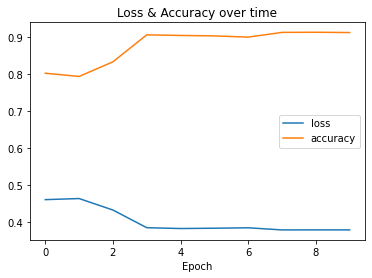

In [ ]:
model3 = SpamClassifier3(
    num_layers=1,
    d_model=16,
    num_heads=4,
    dff=512,
    input_vocab_size = vocab_size,
    maximum_position_encoding=max_sentence_length,
    rate=dropout_rate)

model3.compile(optimizer = 'adam', 
                    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=['accuracy'])
history3 = model3.fit(token_train_set, y_train['label'], batch_size=32, epochs=10)

pd.DataFrame(history3.history).plot(xlabel="Epoch")
plt.title("Loss & Accuracy over time")

y_pred3 = model3.predict(token_test_set)
print(sklearn.metrics.classification_report(y_test['label'].to_numpy(), np.around(y_pred3)))
print()
print()
evaluator(y_test['label'].to_numpy(),np.around(y_pred3).flatten())

Epoch 1/15
76/76 [==============================] - 93s 1s/step - loss: 0.4385 - accuracy: 0.8256
Epoch 2/15
76/76 [==============================] - 78s 1s/step - loss: 0.4023 - accuracy: 0.8747
Epoch 3/15
76/76 [==============================] - 78s 1s/step - loss: 0.3938 - accuracy: 0.8862
Epoch 4/15
76/76 [==============================] - 78s 1s/step - loss: 0.3862 - accuracy: 0.8998
Epoch 5/15
76/76 [==============================] - 78s 1s/step - loss: 0.3845 - accuracy: 0.9040
Epoch 6/15
76/76 [==============================] - 78s 1s/step - loss: 0.3841 - accuracy: 0.9035
Epoch 7/15
76/76 [==============================] - 77s 1s/step - loss: 0.3952 - accuracy: 0.8755
Epoch 8/15
76/76 [==============================] - 77s 1s/step - loss: 0.3895 - accuracy: 0.8928
Epoch 9/15
76/76 [==============================] - 77s 1s/step - loss: 0.3900 - accuracy: 0.8932
Epoch 10/15
76/76 [==============================] - 78s 1s/step - loss: 0.3884 - accuracy: 0.8949
Epoch 11/15
76/76 [

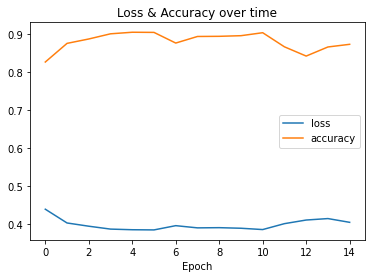

In [ ]:
model4 = SpamClassifier3(
    num_layers=3,
    d_model=16,
    num_heads=4,
    dff=512,
    input_vocab_size = vocab_size,
    maximum_position_encoding=max_sentence_length,
    rate=dropout_rate)

model4.compile(optimizer = 'adam', 
                    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=['accuracy'])
history4 = model4.fit(token_train_set, y_train['label'], batch_size=32, epochs=15)

pd.DataFrame(history4.history).plot(xlabel="Epoch")
plt.title("Loss & Accuracy over time")

y_pred4 = model4.predict(token_test_set)
print(sklearn.metrics.classification_report(y_test['label'].to_numpy(), np.around(y_pred4)))
print()
print()
evaluator(y_test['label'].to_numpy(),np.around(y_pred4).flatten())